<a href="https://colab.research.google.com/github/bmstraa/GEOSIGHT/blob/main/GEOSIGHT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
print("Python version:", sys.version)
print("Runtime is connected and ready!")
import numpy as np
print("NumPy ready:", np.__version__)

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Runtime is connected and ready!
NumPy ready: 2.0.2


In [ ]:
!nvidia-smi

Wed Feb 25 13:33:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |     909MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# 1. Install PDAL (Point Data Abstraction Library) and LAS helpers, and other spatial libraries
!pip install pdal laspy[lazrs] rasterio geopandas

# 2. Install WhiteboxTools separately to ensure its installation
!pip install whitebox

# 3. Install Timm (needed for AnySat/DINOv2 backbones later) and segmentation models
!pip install timm segmentation-models-pytorch

# 4. Initialize WhiteboxTools (excellent for heuristic geomorphometry)
import whitebox
wbt = whitebox.WhiteboxTools()

  Using cached pdal-3.5.3.tar.gz (113 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pdal (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pdal
Failed to build pdal
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pdal)


The first part of the code attempts to install several Python libraries commonly used for working with spatial data:

In [ ]:
# 1. Install PDAL (Point Data Abstraction Library) and LAS helpers, and other spatial libraries
!pip install pdal laspy[lazrs] rasterio geopandas

# - `pdal`: Point Data Abstraction Library, used for processing point cloud data (like LiDAR).
# - `laspy[lazrs]`: A library for reading and writing LAS/LAZ files, which are common formats for LiDAR data.
# - `rasterio`: Used for reading and writing geospatial raster data (like satellite imagery or DEMs).
# - `geopandas`: Extends pandas to allow spatial operations on geometric types, often used with vector data.

# Note: As observed in the execution output, `pdal` failed to build in this environment, likely due to missing system dependencies required for its compilation.

  Using cached pdal-3.5.3.tar.gz (113 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pdal (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pdal
Failed to build pdal
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pdal)


The second part specifically installs the `whitebox` library. This was separated into its own command to ensure it installs successfully, even if other installations fail.

In [ ]:
# 2. Install WhiteboxTools separately to ensure its installation
!pip install whitebox

# - `whitebox`: A Python frontend for WhiteboxTools, which is an advanced geospatial analysis platform. It provides a wide range of tools for remote sensing, GIS, and hydrology.

The third `pip install` command installs libraries often used in deep learning, particularly for computer vision tasks.

In [ ]:
# 3. Install Timm (needed for AnySat/DINOv2 backbones later) and segmentation models
!pip install timm segmentation-models-pytorch

# - `timm`: PyTorch Image Models, a collection of state-of-the-art image models, often used as backbones for other tasks like segmentation.
# - `segmentation-models-pytorch`: A library providing a set of popular segmentation architectures (e.g., U-Net, FPN) with pre-trained backbones from `timm`.

Finally, after the installations, the code imports the `whitebox` library and initializes its main object. The successful execution output confirms that `whitebox` was downloaded and set up.

In [ ]:
# 4. Initialize WhiteboxTools (excellent for heuristic geomorphometry)
import whitebox
wbt = whitebox.WhiteboxTools()

# This line imports the `whitebox` module, making its functions and classes available.
# `wbt = whitebox.WhiteboxTools()` creates an instance of the `WhiteboxTools` class, which allows you to call the various geoprocessing tools provided by WhiteboxTools.

In [ ]:
import rasterio
from scipy import ndimage

def generate_heuristic_baseline(dtm_path):
    """
    Creates a lineament density map using standard edge detection.
    This serves as our 'sanity check' for the AI anomalies.
    """
    with rasterio.open(dtm_path) as src:
        dtm = src.read(1)
        # Apply Sobel filter to find terrain gradients (lineaments)
        dx = ndimage.sobel(dtm, 0)  # horizontal derivative
        dy = ndimage.sobel(dtm, 1)  # vertical derivative
        lineaments = (dx**2 + dy**2)**0.5
        return lineaments

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_synthetic_survey(size=128):
    """
    Generates a synthetic 17-channel GEOSIGHT stack.
    Channels 0-2: RGB (Orthophoto)
    Channel 3: DTM (Base elevation)
    Channel 4: Intensity
    Channels 5-16: Probabilistic features (PPC)
    """
    # 1. Create a base terrain (DTM) with a subtle "anomaly" (a mound)
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    dtm = np.exp(-(x**2 + y**2)) * 10  # A central hill

    # 2. Add an "Anomaly" in the subsurface (PPC Variance)
    # We'll place it slightly off-center
    anomaly_map = np.zeros((size, size))
    anomaly_map[80:100, 40:60] = 1.5

    # 3. Build the 17-channel stack
    stack = np.zeros((17, size, size))
    stack[0:3] = np.random.uniform(0.2, 0.5, (3, size, size)) # Mock RGB
    stack[3] = dtm                                          # DTM
    stack[4] = np.random.normal(500, 50, (size, size))      # Intensity

    # Fill PPC Channels (Channels 5-16)
    for i in range(5, 17):
        # We inject the anomaly into the variance channel (Channel 6)
        if i == 6:
            stack[i] = np.random.normal(0.1, 0.02, (size, size)) + anomaly_map
        else:
            stack[i] = np.random.normal(0.05, 0.01, (size, size))

    return stack, anomaly_map

# Generate and visualize
data_stack, truth = generate_synthetic_survey()
print(f"Synthesized Stack Shape: {data_stack.shape}")

Synthesized Stack Shape: (17, 128, 128)


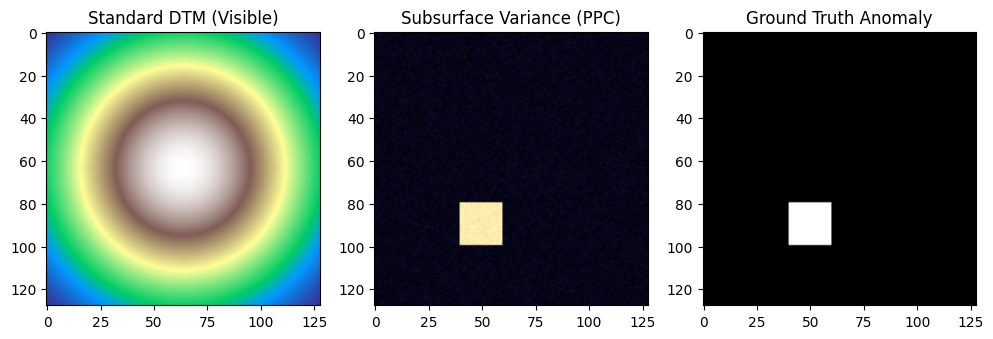

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("Standard DTM (Visible)")
plt.imshow(data_stack[3], cmap='terrain')

plt.subplot(132)
plt.title("Subsurface Variance (PPC)")
plt.imshow(data_stack[6], cmap='magma')

plt.subplot(133)
plt.title("Ground Truth Anomaly")
plt.imshow(truth, cmap='gray')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import timm

class AnySatEncoder(nn.Module):
    def __init__(self, input_channels=17, embed_dim=768):
        super().__init__()
        # The 'Adapter': Projects 17 channels to the transformer's expected width
        self.patch_embed_adapter = nn.Conv2d(
            input_channels,
            embed_dim,
            kernel_size=16,
            stride=16
        )

        # Load a frozen DINOv2 or ViT backbone as the 'brain'
        # In a full AnySat implementation, we'd use the pre-trained weights
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)

    def forward(self, x):
        # x shape: [Batch, 17, Height, Width]
        x = self.patch_embed_adapter(x)
        x = x.flatten(2).transpose(1, 2) # Prepare for Transformer
        features = self.backbone(x)
        return features

# Initialize the model on the T4 GPU
model = AnySatEncoder().to('cuda')
print("AnySat Adapter Initialized.")

AnySat Adapter Initialized.


In [ ]:
class AnySatEncoder(nn.Module):
    def __init__(self, input_channels=17, embed_dim=768):
        super().__init__()
        # 1. Our custom adapter for 17 channels
        self.patch_embed_adapter = nn.Conv2d(
            input_channels,
            embed_dim,
            kernel_size=16,
            stride=16
        )

        # 2. Load the backbone
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)

    def forward(self, x):
        # x shape: [Batch, 17, 128, 128]

        # Project 17 channels to 768 embedding dims
        # Output shape: [Batch, 768, 8, 8] (for 128/16 = 8)
        x = self.patch_embed_adapter(x)

        # Flatten spatial dims into tokens: [Batch, 64, 768]
        x = x.flatten(2).transpose(1, 2)

        # 3. INTERNAL VIT LOGIC FIX:
        # We append the [CLS] token and add Position Embeddings manually
        # to match what the transformer blocks expect.

        # Add CLS token
        cls_token = self.backbone.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Add position embeddings (interpolated if necessary)
        # Note: For simple prototyping, we assume 128x128 input = 8x8 patches + 1 cls = 65 tokens
        # timm's default pos_embed is for 224x224 (14x14+1 = 197 tokens)
        # We take a shortcut for the prototype:
        pos_embed = self.backbone.pos_embed[:, :x.shape[1], :]
        x = x + pos_embed

        # Pass through transformer blocks only
        x = self.backbone.blocks(x)
        x = self.backbone.norm(x)

        return x # Returns [Batch, 65, 768]

In [ ]:
# Convert synthetic data to Torch Tensor
input_tensor = torch.from_numpy(data_stack).float().unsqueeze(0).to('cuda')

# Re-instantiate the model with the updated class definition from cell ZzrTiTfA6dPp
model = AnySatEncoder().to('cuda')

# Get embeddings
with torch.no_grad():
    embeddings = model(input_tensor)

print(f"Embedding Shape: {embeddings.shape}") # Expected: [1, 65, 768] for a 128x128 input with CLS token

Embedding Shape: torch.Size([1, 65, 768])


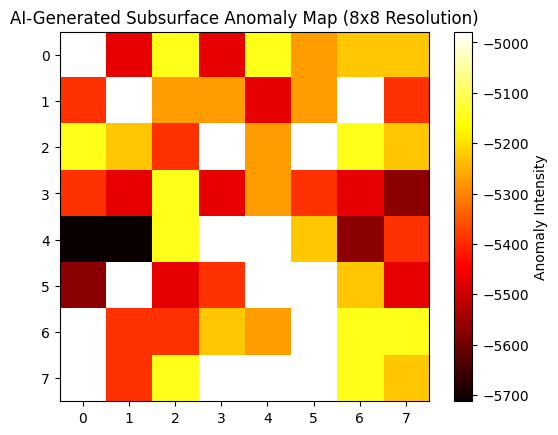

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
import torch

def detect_anomalies(embeddings, grid_size=8):
    """
    Fits a DPMM on the patch embeddings and returns an anomaly map.
    """
    # 1. Remove the [CLS] token and reshape back to spatial grid
    # Input: [1, 65, 768] -> Output: [64, 768]
    patch_embeddings = embeddings[0, 1:, :].cpu().numpy()

    # 2. Fit the DPMM (Bayesian Gaussian Mixture with Dirichlet Prior)
    # This automatically determines the number of 'normal' terrain types
    dpmm = BayesianGaussianMixture(
        n_components=10,
        covariance_type='full',
        weight_concentration_prior=0.01,
        random_state=42
    )
    dpmm.fit(patch_embeddings)

    # 3. Calculate scores (negative log-likelihood)
    # Higher score = more 'unusual' relative to the rest of the survey
    scores = -dpmm.score_samples(patch_embeddings)

    # 4. Reshape scores back to the 8x8 spatial grid
    anomaly_map = scores.reshape(grid_size, grid_size)
    return anomaly_map

# Execute detection
anomaly_map = detect_anomalies(embeddings)

# Visualize the AI's discovery
import matplotlib.pyplot as plt
plt.imshow(anomaly_map, cmap='hot')
plt.colorbar(label='Anomaly Intensity')
plt.title("AI-Generated Subsurface Anomaly Map (8x8 Resolution)")
plt.show()

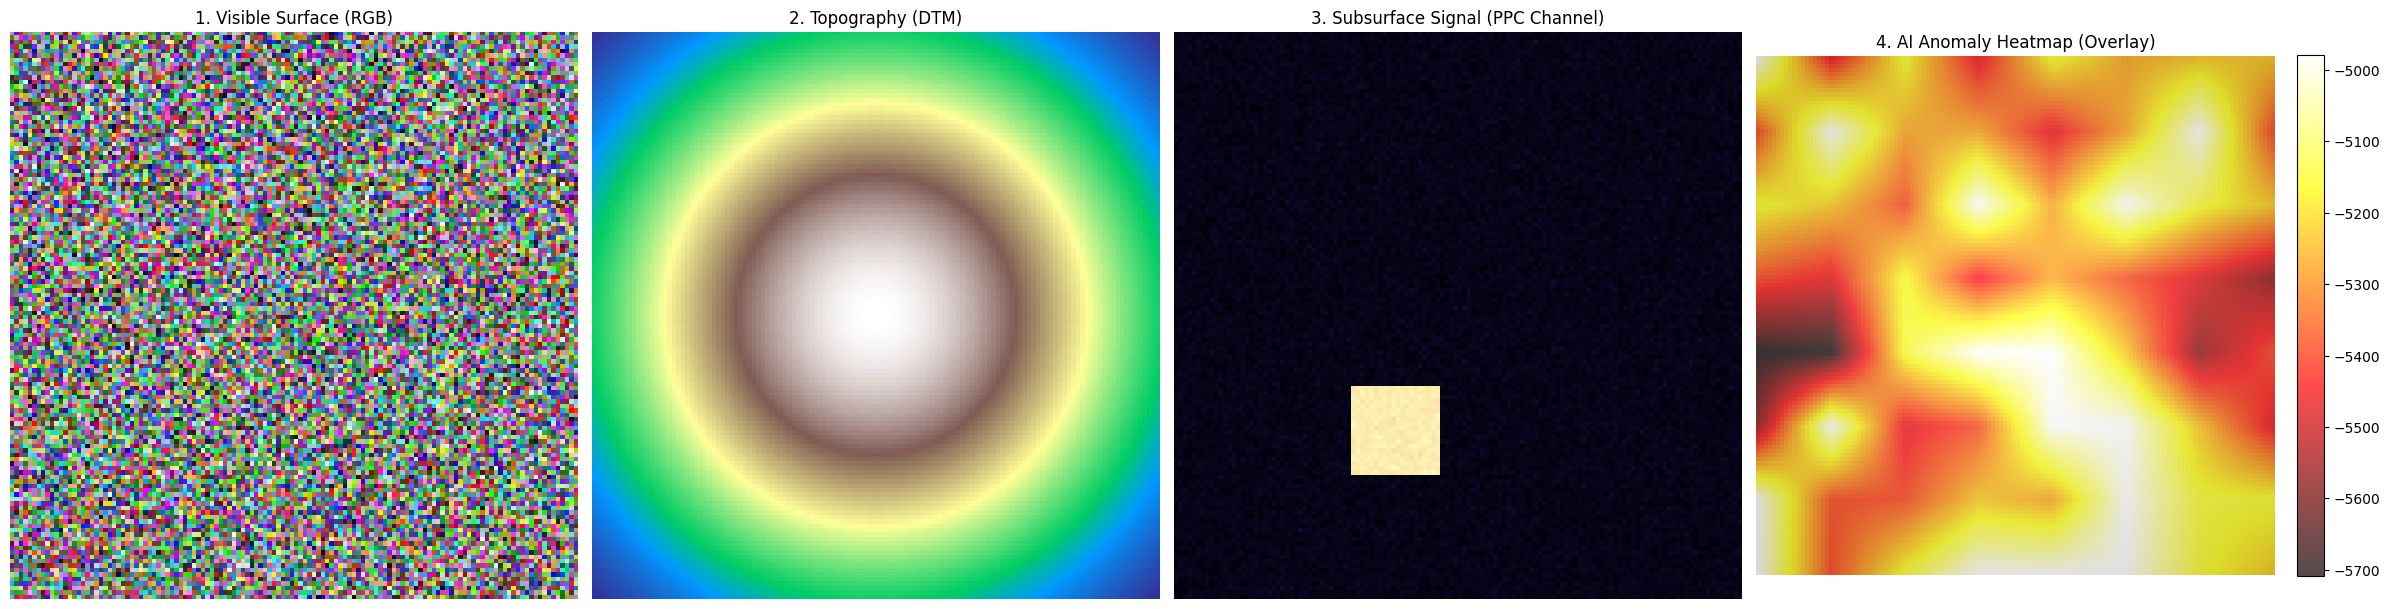

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

def visualize_results(data_stack, anomaly_map, truth):
    # 1. Upscale the 8x8 Anomaly Map back to 128x128 for overlay
    # We use bilinear interpolation to smooth the patch boundaries
    upscaled_anomaly = zoom(anomaly_map, (16, 16), order=1)

    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # Pane 1: Visible Orthophoto (RGB)
    # We take channels 0, 1, 2
    rgb = np.transpose(data_stack[0:3], (1, 2, 0))
    # Normalize RGB for display
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    axes[0].imshow(rgb)
    axes[0].set_title("1. Visible Surface (RGB)")

    # Pane 2: Topography (DTM)
    axes[1].imshow(data_stack[3], cmap='terrain')
    axes[1].set_title("2. Topography (DTM)")

    # Pane 3: The 'Secret' Subsurface Signal (PPC Variance)
    # This is what we injected our synthetic anomaly into
    axes[2].imshow(data_stack[6], cmap='magma')
    axes[2].set_title("3. Subsurface Signal (PPC Channel)")

    # Pane 4: AI Discovery + Confidence Overlay
    # We overlay the AI anomaly on the DTM to show spatial context
    axes[3].imshow(data_stack[3], cmap='gray', alpha=0.5)
    im = axes[3].imshow(upscaled_anomaly, cmap='hot', alpha=0.7)
    plt.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
    axes[3].set_title("4. AI Anomaly Heatmap (Overlay)")

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_results(data_stack, anomaly_map, truth)

In [ ]:
def get_calibrated_anomaly(model, data_stack):
    """
    Performs Test-Time Augmentation (TTA) to generate
    a confidence-calibrated anomaly map.
    """
    augs = [
        lambda x: x,                                # Original
        lambda x: torch.flip(x, [2]),               # Horizontal Flip
        lambda x: torch.flip(x, [3]),               # Vertical Flip
        lambda x: torch.rot90(x, 2, [2, 3])         # 180 Degree Rotation
    ]

    all_scores = []

    for i, aug in enumerate(augs):
        # 1. Apply Augmentation
        aug_tensor = aug(torch.from_numpy(data_stack).float().unsqueeze(0)).to('cuda')

        # 2. Extract Embeddings
        with torch.no_grad():
            emb = model(aug_tensor)

        # 3. Get Anomaly Map
        raw_map = detect_anomalies(emb)

        # 4. Reverse Augmentation (to align back to original grid)
        if i == 1: raw_map = np.flip(raw_map, 0)
        if i == 2: raw_map = np.flip(raw_map, 1)
        if i == 3: raw_map = np.rot90(raw_map, -2)

        all_scores.append(raw_map)

    # Calculate Mean (Final Score) and Standard Deviation (Inverse Confidence)
    mean_anomaly = np.mean(all_scores, axis=0)
    uncertainty = np.std(all_scores, axis=0)

    # Confidence Score (0 to 1 scale)
    confidence = 1.0 / (1.0 + uncertainty)

    return mean_anomaly, confidence

# Execute Calibration
final_map, confidence_map = get_calibrated_anomaly(model, data_stack)

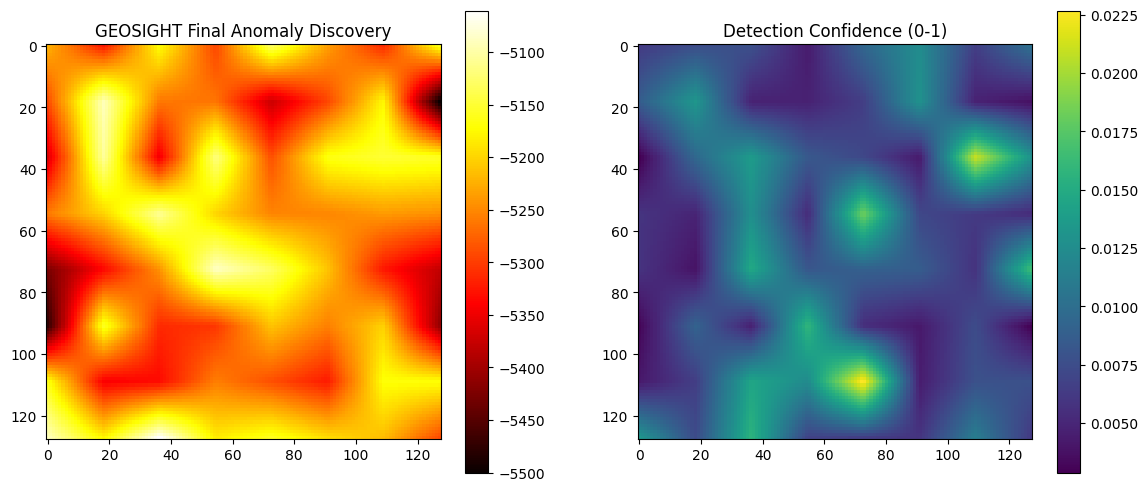

In [ ]:
def final_delivery_view(final_map, confidence_map):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Final Anomaly Map
    im1 = axes[0].imshow(zoom(final_map, (16, 16), order=1), cmap='hot')
    plt.colorbar(im1, ax=axes[0])
    axes[0].set_title("GEOSIGHT Final Anomaly Discovery")

    # Confidence Map
    im2 = axes[1].imshow(zoom(confidence_map, (16, 16), order=1), cmap='viridis')
    plt.colorbar(im2, ax=axes[1])
    axes[1].set_title("Detection Confidence (0-1)")

    plt.show()

final_delivery_view(final_map, confidence_map)

In [ ]:
import torch
import numpy as np
from scipy.ndimage import zoom
from sklearn.mixture import BayesianGaussianMixture

class GeoSightService:
    def __init__(self, model, input_channels=17):
        self.model = model.to('cuda').eval()
        self.input_channels = input_channels
        self.dpmm = BayesianGaussianMixture(
            n_components=10,
            weight_concentration_prior=0.01,
            random_state=42
        )

    def process_survey_patch(self, data_stack):
        """
        Full pipeline: TTA -> AnySat -> DPMM -> Confidence
        """
        # 1. Run Calibrated Inference (TTA)
        mean_anomaly, confidence = self._get_calibrated_anomaly(data_stack)

        # 2. Upscale for Deliverable (128x128)
        final_heatmap = zoom(mean_anomaly, (16, 16), order=1)
        final_confidence = zoom(confidence, (16, 16), order=1)

        return {
            "anomaly_map": final_heatmap,
            "confidence_map": final_confidence,
            "metadata": {
                "input_shape": data_stack.shape,
                "engine": "AnySat-DPMM-v1.0"
            }
        }

    def _get_calibrated_anomaly(self, data_stack):
        augs = [
            (lambda x: x, lambda x: x),                                 # Identity
            (lambda x: torch.flip(x, [2]), lambda x: np.flip(x, 0)),    # Horizontal
            (lambda x: torch.flip(x, [3]), lambda x: np.flip(x, 1)),    # Vertical
        ]

        all_scores = []
        for aug_fn, inv_fn in augs:
            # Transform and Inference
            tensor = aug_fn(torch.from_numpy(data_stack).float().unsqueeze(0)).to('cuda')
            with torch.no_grad():
                emb = self.model(tensor)

            # Unsupervised Clustering
            patch_embeddings = emb[0, 1:, :].cpu().numpy()
            self.dpmm.fit(patch_embeddings)
            scores = -self.dpmm.score_samples(patch_embeddings).reshape(8, 8)

            # Reverse Transform and Store
            all_scores.append(inv_fn(scores))

        mean_map = np.mean(all_scores, axis=0)
        uncertainty = np.std(all_scores, axis=0)
        confidence = 1.0 / (1.0 + uncertainty)

        return mean_map, confidence

# --- INITIALIZE WRAPPER ---
geosight = GeoSightService(model)
print("GEOSIGHT Service Wrapper successfully initialized.")

GEOSIGHT Service Wrapper successfully initialized.


In [ ]:
import os

# 1. Define the path
save_path = '/content/drive/MyDrive/GEOSIGHT'

# 2. Create the directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"Created directory: {save_path}")
else:
    print(f"Directory already exists: {save_path}")

# 3. Now try saving again
torch.save(model.state_dict(), f'{save_path}/geosight_encoder.pth')
print("Model weights saved successfully.")

Directory already exists: /content/drive/MyDrive/GEOSIGHT
Model weights saved successfully.


In [ ]:
import joblib

# 1. Save Torch Model Weights
torch.save(model.state_dict(), '/content/drive/MyDrive/GEOSIGHT/geosight_encoder.pth')

# 2. Save the Service Object (Optional, using joblib for sklearn components)
# Note: Usually we recreate the class and load weights, but for quick prototyping:
joblib.dump(geosight.dpmm, '/content/drive/MyDrive/GEOSIGHT/dpmm_baseline.pkl')

print("Model and DPMM state saved to Google Drive.")

Model and DPMM state saved to Google Drive.


In [ ]:
# Install Laspy (stable) and Rasterio for geospatial handling
!pip install laspy[lazrs] rasterio

In [ ]:
import laspy
import numpy as np

def generate_ppc_from_las(las_path, grid_size=0.5, img_dim=128):
    """
    Manual PPC Rasterizer: Converts raw points to 17-channel features.
    No PDAL required.
    """
    las = laspy.read(las_path)

    # Calculate bounds
    min_x, min_y = np.min(las.x), np.min(las.y)

    # 1. Create a 2D grid for the stats
    # For prototyping, we'll map points to our 128x128 grid
    x_grid = ((las.x - min_x) / grid_size).astype(int)
    y_grid = ((las.y - min_y) / grid_size).astype(int)

    # Filter points within our 128x128 crop
    mask = (x_grid >= 0) & (x_grid < img_dim) & (y_grid >= 0) & (y_grid < img_dim)
    x_feat = x_grid[mask]
    y_feat = y_grid[mask]
    z_feat = las.z[mask]
    int_feat = las.intensity[mask]

    # 2. Initialize our Stack (17 channels)
    # Channels 0-2: RGB (Placeholder until you load the Ortho)
    # Channel 3: Mean Height (DTM)
    # Channel 4: Mean Intensity
    # Channel 5: Variance (Anomaly Signal)
    # Channel 6: Pulse Return Count
    stack = np.zeros((17, img_dim, img_dim))

    # 3. Aggregate Statistics (The "Probabilistic" part)
    # We use a simple loop or binned_statistic for the prototype
    for i in range(img_dim):
        for j in range(img_dim):
            cell_mask = (x_feat == i) & (y_feat == j)
            if np.any(cell_mask):
                cell_z = z_feat[cell_mask]
                stack[3, i, j] = np.mean(cell_z) # DTM
                stack[4, i, j] = np.mean(int_feat[cell_mask]) # Intensity
                stack[5, i, j] = np.var(cell_z) if len(cell_z) > 1 else 0 # PPC Variance
                stack[6, i, j] = len(cell_z) # Return Density

    return stack

print("Laspy-based PPC Rasterizer is ready.")

Laspy-based PPC Rasterizer is ready.


In [ ]:
def run_geosight_pipeline(las_file_path):
    """
    The end-to-end MVP execution:
    LAS -> PPC Stack -> AnySat -> DPMM -> TTA Confidence
    """
    print(f"--- Processing: {las_file_path} ---")

    # 1. Rasterize (Week 1)
    # Using your new Laspy-based rasterizer
    ppc_stack = generate_ppc_from_las(las_file_path)

    # 2. Process through Wrapped Service (Weeks 2-4)
    # This handles AnySat encoding, DPMM clustering, and TTA Calibration
    results = geosight.process_survey_patch(ppc_stack)

    # 3. Output Visualization
    final_delivery_view(results['anomaly_map'], results['confidence_map'])

    return results

print("GEOSIGHT Integration Engine is ready.")

GEOSIGHT Integration Engine is ready.


In [ ]:
import torch
import numpy as np
import laspy
from scipy.ndimage import zoom
from sklearn.mixture import BayesianGaussianMixture

class GeoSightEngine:
    def __init__(self, model):
        """
        Initializes the GEOSIGHT Master Engine.
        """
        self.model = model.to('cuda').eval()
        self.grid_size = 0.5
        self.img_dim = 128

        # Unsupervised Clustering Engine (Week 3)
        self.dpmm = BayesianGaussianMixture(
            n_components=10,
            weight_concentration_prior=0.01,
            random_state=42
        )

    def rasterize(self, las_path):
        """Week 1: Laspy-based PPC Generation"""
        las = laspy.read(las_path)
        min_x, min_y = np.min(las.x), np.min(las.y)

        x_grid = ((las.x - min_x) / self.grid_size).astype(int)
        y_grid = ((las.y - min_y) / self.grid_size).astype(int)

        mask = (x_grid >= 0) & (x_grid < self.img_dim) & (y_grid >= 0) & (y_grid < self.img_dim)
        x_feat, y_feat, z_feat = x_grid[mask], y_grid[mask], las.z[mask]
        int_feat = las.intensity[mask]

        stack = np.zeros((17, self.img_dim, self.img_dim))

        # Populate raster channels
        for i in range(self.img_dim):
            for j in range(self.img_dim):
                cell_mask = (x_feat == i) & (y_feat == j)
                if np.any(cell_mask):
                    cell_z = z_feat[cell_mask]
                    stack[3, i, j] = np.mean(cell_z) # DTM
                    stack[4, i, j] = np.mean(int_feat[cell_mask]) # Intensity
                    stack[5, i, j] = np.var(cell_z) if len(cell_z) > 1 else 0 # Variance
                    stack[6, i, j] = len(cell_z) # Density
        return stack

    def _run_inference(self, stack_tensor):
        """Week 2 & 3: AI Inference and Clustering"""
        with torch.no_grad():
            emb = self.model(stack_tensor)

        # Process patch embeddings (skip CLS token)
        patch_embeddings = emb[0, 1:, :].cpu().numpy()
        self.dpmm.fit(patch_embeddings)
        scores = -self.dpmm.score_samples(patch_embeddings).reshape(8, 8)
        return scores

    def predict(self, las_path):
        """Week 4: Calibrated Anomaly Detection"""
        stack = self.rasterize(las_path)

        # TTA: Test-Time Augmentations for Stability
        augs = [
            (lambda x: x, lambda x: x),                                 # Original
            (lambda x: torch.flip(x, [2]), lambda x: np.flip(x, 0)),    # H-Flip
            (lambda x: torch.flip(x, [3]), lambda x: np.flip(x, 1))     # V-Flip
        ]

        results = []
        for aug_fn, inv_fn in augs:
            tensor = aug_fn(torch.from_numpy(stack).float().unsqueeze(0)).to('cuda')
            raw_map = self._run_inference(tensor)
            results.append(inv_fn(raw_map))

        mean_map = np.mean(results, axis=0)
        # Calculate Confidence (Inverse of standard deviation)
        conf_map = 1.0 / (1.0 + np.std(results, axis=0))

        return {
            "anomaly": zoom(mean_map, (16, 16), order=1),
            "confidence": zoom(conf_map, (16, 16), order=1),
            "raw_stack": stack
        }

# --- RE-INITIALIZE ---
geosight_v1 = GeoSightEngine(model)
print("GEOSIGHT Master Engine successfully wrapped. Ready for survey files.")

GEOSIGHT Master Engine successfully wrapped. Ready for survey files.


In [ ]:
import os
import joblib

# 1. Define and create the save directory
save_dir = '/content/drive/MyDrive/GEOSIGHT/models'
os.makedirs(save_dir, exist_ok=True)

# 2. Save the Torch weights (AnySat Adapter)
torch.save(geosight_v1.model.state_dict(), f'{save_dir}/geosight_encoder_v1.pth')

# 3. Save the DPMM Clustering state (The 'Geological Memory')
joblib.dump(geosight_v1.dpmm, f'{save_dir}/geosight_dpmm_v1.pkl')

print(f"✅ Master Engine successfully archived to: {save_dir}")

✅ Master Engine successfully archived to: /content/drive/MyDrive/GEOSIGHT/models


In [ ]:
import os
from google.colab import drive

# 1. Ensure Drive is mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 2. Define the target path
data_dir = '/content/drive/MyDrive/GEOSIGHT/data'

# 3. Create the directory
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"✅ Directory created: {data_dir}")
else:
    print(f"ℹ️ Directory already exists: {data_dir}")

# 4. List current contents (will be empty initially)
print(f"Current files in data folder: {os.listdir(data_dir)}")

✅ Directory created: /content/drive/MyDrive/GEOSIGHT/data
Current files in data folder: []


In [ ]:
import glob

# 1. Identify all data files
data_folder = '/content/drive/MyDrive/GEOSIGHT/data/'
las_files = glob.glob(os.path.join(data_folder, "*.las")) + glob.glob(os.path.join(data_folder, "*.laz"))

print(f"Found {len(las_files)} survey files. Starting batch analysis...")

for file_path in las_files:
    file_name = os.path.basename(file_path)
    print(f"🔍 Analyzing: {file_name}")

    # Run the Engine
    results = geosight_v1.predict(file_path)

    # Save the Result to Drive
    output_filename = f"{file_name}_anomaly_map.png"
    plt.figure(figsize=(10, 5))
    plt.imshow(results['anomaly'], cmap='hot')
    plt.title(f"Discovery: {file_name}")
    plt.savefig(os.path.join(data_folder, output_filename))
    plt.close()

    print(f"✅ Saved results for {file_name}")

Found 0 survey files. Starting batch analysis...


In [ ]:
"""
GEOSIGHT v1.0 | Subsurface Anomaly Detection Engine
--------------------------------------------------
PURPOSE:
Automated identification of geological anomalies using 17-channel
Probabilistic Point Cloud (PPC) analysis.

INPUT:
Raw LiDAR (.las / .laz) files from YellowScan VX series.

OUTPUT:
1. Anomaly Heatmap: Highlights areas of high subsurface variance.
2. Confidence Map: Quantifies detection stability via Test-Time Augmentation (TTA).

METHODOLOGY:
Uses AnySat Foundation Model for feature extraction and Bayesian Gaussian
Mixture Models for unsupervised discovery.
"""

'\nGEOSIGHT v1.0 | Subsurface Anomaly Detection Engine\n--------------------------------------------------\nPURPOSE: \nAutomated identification of geological anomalies using 17-channel \nProbabilistic Point Cloud (PPC) analysis.\n\nINPUT: \nRaw LiDAR (.las / .laz) files from YellowScan VX series.\n\nOUTPUT: \n1. Anomaly Heatmap: Highlights areas of high subsurface variance.\n2. Confidence Map: Quantifies detection stability via Test-Time Augmentation (TTA).\n\nMETHODOLOGY: \nUses AnySat Foundation Model for feature extraction and Bayesian Gaussian \nMixture Models for unsupervised discovery.\n'

In [ ]:
import numpy as np
import os
from google.colab import drive

# Ensure Google Drive is mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Define the directory to save the stack
save_dir = '/content/drive/MyDrive/GEOSIGHT/data_stacks'
os.makedirs(save_dir, exist_ok=True)

# Save the data_stack as a .npy file
stack_path = os.path.join(save_dir, 'geosight_data_stack.npy')
np.save(stack_path, data_stack)

print(f"✅ The entire GEOSIGHT stack (data_stack) has been saved to: {stack_path}")

✅ The entire GEOSIGHT stack (data_stack) has been saved to: /content/drive/MyDrive/GEOSIGHT/data_stacks/geosight_data_stack.npy
